**HOMEWORK 2**

*[Ερώτημα 1: Feedforward Neural Network]*

1. Φόρτωση δεδομένων (mfccs)

In [31]:
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import time
import random
import torch.optim as optim


from pytube import YouTube
from pydub import AudioSegment
import torchaudio
from pydub.utils import which
AudioSegment.converter = which("ffmpeg")
import librosa
import tempfile

In [65]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
    def get_shapes(self):
        return self.features.shape, self.labels.shape

In [3]:


# Φόρτωση train dataset (numpy) (3200,26)
train = np.load(r'D:\desktop\ML\mfccs\train\X.npy')
train_labels = np.load(r'D:\desktop\ML\mfccs\train\labels.npy')
# print(train.shape)
# print(train_labels.shape)


# Φόρτωση test dataset (numpy) (1376,26)
test = np.load(r'D:\desktop\ML\mfccs\test\X.npy')
test_labels = np.load(r'D:\desktop\ML\mfccs\test\labels.npy')
# print(test.shape)
# print(test_labels.shape)

# Φόρτωση validate dataset (numpy) (800,26)
validate = np.load(r'D:\desktop\ML\mfccs\validate\X.npy')
validate_labels = np.load(r'D:\desktop\ML\mfccs\validate\labels.npy')
# print(validate.shape)
# print(validate_labels)



genre_to_int = {
    'classical': 1,
    'blues': 0,
    'hiphop': 2,
    'rock_metal_hardrock': 3
}

def convert_labels(labels, mapping):
    return np.array([mapping[label] for label in labels])

# Μετατροπή των Labels αρχείων 
train_labels_int = convert_labels(train_labels, genre_to_int)
test_labels_int = convert_labels(test_labels, genre_to_int)
validate_labels_int = convert_labels(validate_labels, genre_to_int)
# print(train_labels_int)


In [4]:
# Δημιουργία των datasets
train_dataset = CustomDataset(train, train_labels_int)
test_dataset = CustomDataset(test, test_labels_int)
validate_dataset = CustomDataset(validate, validate_labels_int)

# Εκτύπωση διαστάσεων
train_shapes = train_dataset.get_shapes()
test_shapes = test_dataset.get_shapes()
validate_shapes = validate_dataset.get_shapes()

print(f"Train Dataset Features Shape: {train_shapes[0]}")
print(f"Train Dataset Labels Shape: {train_shapes[1]}")
print(f"Test Dataset Features Shape: {test_shapes[0]}")
print(f"Test Dataset Labels Shape: {test_shapes[1]}")
print(f"Validate Dataset Features Shape: {validate_shapes[0]}")
print(f"Validate Dataset Labels Shape: {validate_shapes[1]}")


Train Dataset Features Shape: torch.Size([3200, 26])
Train Dataset Labels Shape: torch.Size([3200])
Test Dataset Features Shape: torch.Size([1376, 26])
Test Dataset Labels Shape: torch.Size([1376])
Validate Dataset Features Shape: torch.Size([800, 26])
Validate Dataset Labels Shape: torch.Size([800])


In [5]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=16, shuffle=True)


# i = 0
# for features, labels in train_loader:
#     print(features.shape, labels.shape)
#     i = i + 1
    
# print(f"Τα branch είναι i {i}")

Ορισμός Νευρωνικού Δικτύου

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

Ορισμός διαδικασίας εκπαίδευσης 

In [7]:
def train_model(model, dataloader, criterion, optimizer, num_epochs, use_gpu="off"):
    # Ανάλογα με την τιμή του use_gpu, καθορίζουμε τη συσκευή
    device = torch.device("cuda" if use_gpu == "on" and torch.cuda.is_available() else "cpu")
    print(device)
    # Μεταφορά του μοντέλου στη συσκευή
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()  # Θέτουμε το μοντέλο σε κατάσταση εκπαίδευσης
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            
            # Ανάλογα με την τιμή του use_gpu, μεταφέρουμε τα δεδομένα στη συσκευή
            inputs = inputs.to(device)
            labels = labels.to(device)
             
            # Προώθηση (forward pass)
            outputs = model(inputs)
            
            # Υπολογισμός του loss
            loss = criterion(outputs, labels)
            
            # Οπισθοδιάδοση (backward pass)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Συγκέντρωση του running loss
            running_loss += loss.item()
        
        # Εκτύπωση του μέσου loss ανά εποχή
        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    print("Finished Training")
    return model

Ορισμός διαδικασίας αξιολόγησης

In [8]:
def test_loop(dataloader, model, loss_fn, use_gpu="off"):
    model.eval()
    # Ανάλογα με την τιμή του use_gpu, καθορίζουμε τη συσκευή
    device = torch.device("cuda" if use_gpu == "on" and torch.cuda.is_available() else "cpu")
    print(device)
    # Μεταφορά του μοντέλου στη συσκευή
    model.to(device)
    
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    all_labels = []
    all_predictions = []

    # η εντολή no_grad λέει στο PyTorch ότι δεν θέλουμε να συσσωρεύσουμε gradients για αυτές τις λειτουργίες
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Ανάλογα με την τιμή του use_gpu, μεταφέρουμε τα δεδομένα στη συσκευή
            inputs = inputs.to(device)
            labels = labels.to(device)

            pred = model(inputs)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

            # Συλλογή ετικετών και προβλέψεων για περαιτέρω μετρικές
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(pred.argmax(1).cpu().numpy())

    test_loss /= size
    correct /= size

    # Υπολογισμός επιπλέον μετρικών
    f1 = f1_score(all_labels, all_predictions, average='macro')
    accuracy = accuracy_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Accuracy: {accuracy:>0.1f}\n")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return test_loss, f1, accuracy, conf_matrix


Εκπαίδευση δικτύου -  Εκπαίδευση δικτύου με GPU

In [9]:
# Διαστάσεις του δικτύου
input_dim = 26
hidden_dim1 = 128
hidden_dim2 = 32
output_dim = 4


model = NeuralNetwork(input_dim, hidden_dim1, hidden_dim2, output_dim)
# print(model)
# Ορισμός του loss function και του optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.002)


num_epochs = 30



# Εκπαίδευση του μοντέλου χρησιμοποιώντας τον train_loader από το προηγούμενο βήμα και αξιολογώντας με την test_loader (χωρις GPU)
start_time = time.time()
trained_model1 = train_model(model, train_loader, criterion, optimizer, num_epochs)
end_time = time.time()
cpu_training_time = end_time - start_time
print(f"CPU Training Time: {cpu_training_time:.2f} seconds")

start_time = time.time()
val_loss, val_f1, val_accuracy, val_conf_matrix = test_loop(test_loader, trained_model1, criterion)
end_time = time.time()
cpu_testing_time = end_time - start_time
print(f"CPU Testing Time: {cpu_testing_time:.2f} seconds")



model = NeuralNetwork(input_dim, hidden_dim1, hidden_dim2, output_dim)
# Ορισμός του loss function και του optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.002)



# Εκπαίδευση του μοντέλου χρησιμοποιώντας τον train_loader από το προηγούμενο βήμα και αξιολογώντας με την test_loader (με GPU)
start_time = time.time()
trained_model2 = train_model(model, train_loader, criterion, optimizer, num_epochs,use_gpu="on")
end_time = time.time()
gpu_training_time = end_time - start_time
print(f"GPU Training Time: {gpu_training_time:.2f} seconds")

start_time = time.time()
val_loss, val_f1, val_accuracy, val_conf_matrix = test_loop(test_loader, trained_model2, criterion,use_gpu="on")
end_time = time.time()
gpu_testing_time = end_time - start_time
print(f"GPU Testing Time: {gpu_testing_time:.2f} seconds")

cpu
Epoch [1/30], Loss: 1.3851
Epoch [2/30], Loss: 1.3569
Epoch [3/30], Loss: 1.3326
Epoch [4/30], Loss: 1.3099
Epoch [5/30], Loss: 1.2834
Epoch [6/30], Loss: 1.2559
Epoch [7/30], Loss: 1.2288
Epoch [8/30], Loss: 1.1961
Epoch [9/30], Loss: 1.1720
Epoch [10/30], Loss: 1.1464
Epoch [11/30], Loss: 1.1189
Epoch [12/30], Loss: 1.0945
Epoch [13/30], Loss: 1.0781
Epoch [14/30], Loss: 1.0602
Epoch [15/30], Loss: 1.0468
Epoch [16/30], Loss: 1.0294
Epoch [17/30], Loss: 1.0157
Epoch [18/30], Loss: 0.9981
Epoch [19/30], Loss: 0.9931
Epoch [20/30], Loss: 0.9897
Epoch [21/30], Loss: 0.9843
Epoch [22/30], Loss: 0.9695
Epoch [23/30], Loss: 0.9569
Epoch [24/30], Loss: 0.9548
Epoch [25/30], Loss: 0.9517
Epoch [26/30], Loss: 0.9467
Epoch [27/30], Loss: 0.9493
Epoch [28/30], Loss: 0.9332
Epoch [29/30], Loss: 0.9403
Epoch [30/30], Loss: 0.9384
Finished Training
CPU Training Time: 4.45 seconds
cpu
Accuracy: 0.6

F1 Score: 0.6265
Confusion Matrix:
[[ 99  30  85 110]
 [ 27 243  13  14]
 [ 57  14 268  17]
 [ 5

Επιλογή μοντέλου

In [10]:
def train_model_best(model, train_loader,val_loader, criterion, optimizer, num_epochs, use_gpu="off"):
    device = torch.device("cuda" if use_gpu == "on" and torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    
    best_model_wts = None
    best_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        val_loss, val_f1, val_accuracy, val_conf_matrix = test_loop(val_loader,model,criterion)

        if val_f1 > best_f1:
            epoch_best = epoch
            best_f1 = val_f1
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    print(f"epoch Best={epoch_best+1}")
    print("Finished Training")
    return model

In [11]:
# Διαστάσεις του δικτύου
input_dim = 26
hidden_dim1 = 128
hidden_dim2 = 32
output_dim = 4


model = NeuralNetwork(input_dim, hidden_dim1, hidden_dim2, output_dim)
# print(model)
# Ορισμός του loss function και του optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.002)


num_epochs = 30
trained_model3 = train_model_best(model, train_loader, validate_loader, criterion, optimizer, num_epochs)

val_loss, val_f1, val_accuracy, val_conf_matrix = test_loop(test_loader, trained_model3, criterion)



cpu
Epoch [1/30], Loss: 1.3831
cpu
Accuracy: 0.3

F1 Score: 0.2047
Confusion Matrix:
[[  0   0 198   2]
 [  0   0 197   3]
 [  0   0 199   1]
 [  0   0 149  51]]
Epoch [2/30], Loss: 1.3496
cpu
Accuracy: 0.4

F1 Score: 0.2982
Confusion Matrix:
[[  0 140   0  60]
 [  0 194   0   6]
 [  0 113   1  86]
 [  0  42   0 158]]
Epoch [3/30], Loss: 1.3269
cpu
Accuracy: 0.3

F1 Score: 0.1625
Confusion Matrix:
[[  7   1   0 192]
 [ 10  19   0 171]
 [ 18   0   0 182]
 [  3   0   0 197]]
Epoch [4/30], Loss: 1.3054
cpu
Accuracy: 0.5

F1 Score: 0.3832
Confusion Matrix:
[[  0  35 165   0]
 [  0 177  23   0]
 [  0   8 192   0]
 [  0  19 158  23]]
Epoch [5/30], Loss: 1.2773
cpu
Accuracy: 0.5

F1 Score: 0.4613
Confusion Matrix:
[[ 89  31   0  80]
 [  7 140   3  50]
 [121   5   7  67]
 [ 14   4   0 182]]
Epoch [6/30], Loss: 1.2525
cpu
Accuracy: 0.4

F1 Score: 0.3224
Confusion Matrix:
[[  2  14  12 172]
 [  0  67   8 125]
 [  1   0  44 155]
 [  0   1   2 197]]
Epoch [7/30], Loss: 1.2230
cpu
Accuracy: 0.6

F1

***Σχολιασμός Βήματος 5-7***
H επιλογή του βέλτιστου μοντέλου δεν φέρνει πάντα τα αντίστοιχα αποτελέσματα. Χωρίς την επιλογή του βέλτιστου μοντέλου είχαμε καλύτερα ποσοστό επιτυχίας και καλύτερους Confusion Matrix.(62% με CPU και 60% με GPU) Οπως και στο Epoch 26 ετσι και εδω βλεπουμε οτι το 1ο ειδος μουσικης καθως και το τελευταιο δεν προβλεπονται σωστα. Επισης το Epoch 26 που ειναι το βελτιστο εχει ποσοστο επιτυχιας 68.9 στο συγκεκριμενο μοντέλο ενώ το με το validate_set βλεπουμε οτι εχει 58.6 ποσοστό επιτυχίας. Συγκριτικά τα αποτελέσματα και με GPU αλλά και με CPU ήταν καλύτερα. 

***Σχολιασμός Βήματος 6***
Επιπρόσθετα παρατηρώ οι χρόνοι με CPU καθώς και τα αποτελέσματα στον προσωπικό μου υπολογιστή (Χρησιμοποίησα GPU και CPU του προσωπικού μου υπολογιστή μέσω VS Code και οχι του Colab) είναι καλύτεροι απο ότι με GPU.

**Ερώτημα 2ο: Convolutional Neural Network**

Φόρτωση δεδομένων (spectrograms)

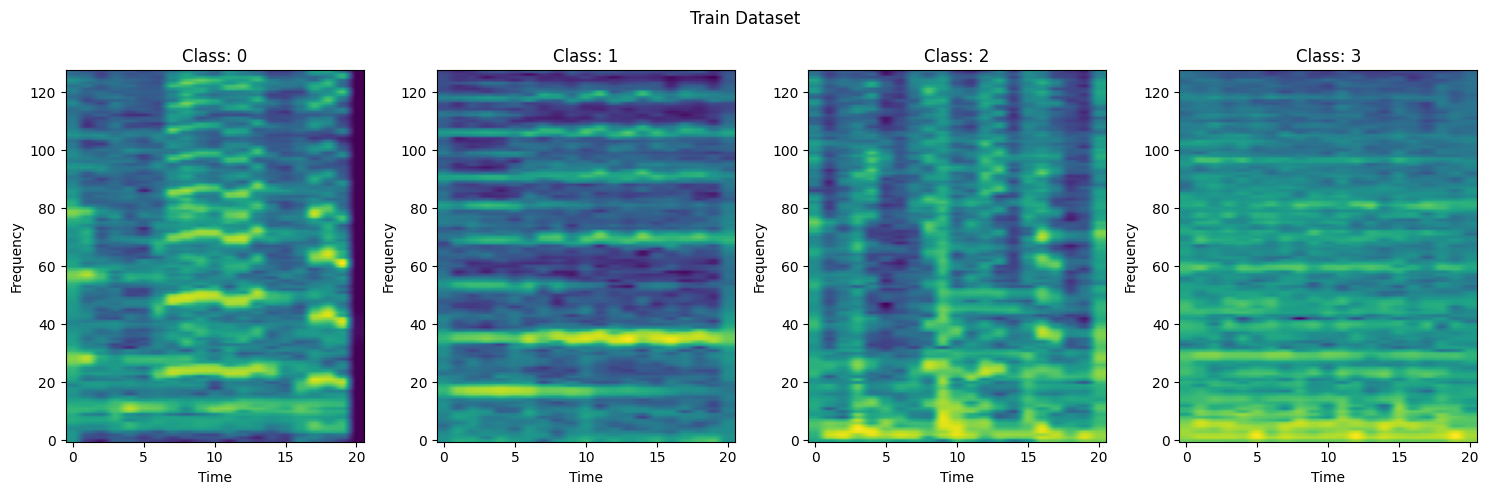

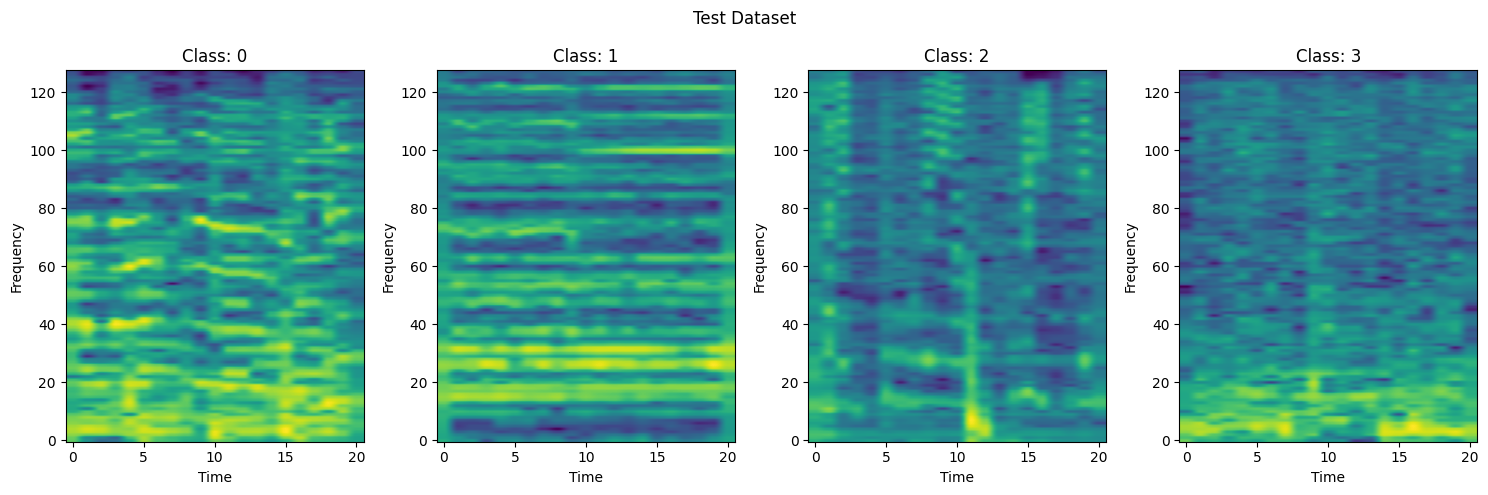

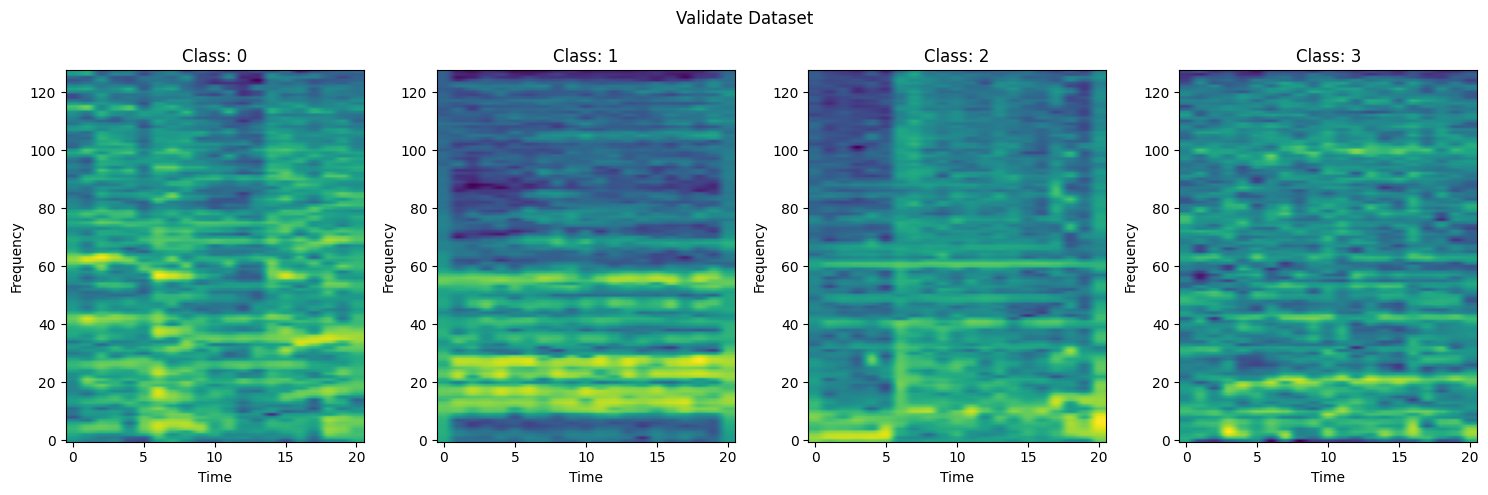

Train Loader Batch 1 - Features Shape: torch.Size([16, 21, 128]), Labels Shape: torch.Size([16])
Train Loader Batch 2 - Features Shape: torch.Size([16, 21, 128]), Labels Shape: torch.Size([16])
Train Loader Batch 3 - Features Shape: torch.Size([16, 21, 128]), Labels Shape: torch.Size([16])
Train Loader Batch 4 - Features Shape: torch.Size([16, 21, 128]), Labels Shape: torch.Size([16])
Train Loader Batch 5 - Features Shape: torch.Size([16, 21, 128]), Labels Shape: torch.Size([16])
Train Loader Batch 6 - Features Shape: torch.Size([16, 21, 128]), Labels Shape: torch.Size([16])
Train Loader Batch 7 - Features Shape: torch.Size([16, 21, 128]), Labels Shape: torch.Size([16])
Train Loader Batch 8 - Features Shape: torch.Size([16, 21, 128]), Labels Shape: torch.Size([16])
Train Loader Batch 9 - Features Shape: torch.Size([16, 21, 128]), Labels Shape: torch.Size([16])
Train Loader Batch 10 - Features Shape: torch.Size([16, 21, 128]), Labels Shape: torch.Size([16])
Train Loader Batch 11 - Featu

In [32]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
    def get_shapes(self):
        return self.features.shape, self.labels.shape


def visualize_random_samples(features, labels_int,title):
    classes = np.unique(labels_int)

    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    for i, cls in enumerate(classes):
        idx = np.random.choice(np.where(labels_int == cls)[0])
        mel_spectrogram = features[idx]

        ax = axes[i]
        ax.imshow(mel_spectrogram.T, aspect='auto', origin='lower')
        ax.set_title(f'Class: {cls}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Φόρτωση train dataset (numpy) 
train_mel = np.load(r'D:\desktop\ML\melgrams\train\X.npy')
train_labels_mel = np.load(r'D:\desktop\ML\melgrams\train\labels.npy')
# print(train.shape) # (3200,21,128)
# print(train_labels.shape) # (3200)


# Φόρτωση test dataset (numpy) 
test_mel = np.load(r'D:\desktop\ML\melgrams\test\X.npy')
test_labels_mel = np.load(r'D:\desktop\ML\melgrams\test\labels.npy')
# print(test.shape) #(1376,21,128)
# print(test_labels.shape) #(1376)

# Φόρτωση validate dataset (numpy) 
validate_mel = np.load(r'D:\desktop\ML\melgrams\validate\X.npy')
validate_labels_mel = np.load(r'D:\desktop\ML\melgrams\validate\labels.npy')
# print(validate.shape) # (800,21,128)
# print(validate_labels.shape) # (800)
# print(validate_labels[0])

genre_mel_to_int = {
    'classical': 1,
    'blues': 0,
    'hiphop': 2,
    'rock_metal_hardrock': 3
}

def convert_labels_mel(labels, mapping):
    return np.array([mapping[label] for label in labels])

# Μετατροπή των Labels αρχείων 
train_labels_mel_int = convert_labels_mel(train_labels_mel, genre_mel_to_int)
test_labels_mel_int = convert_labels_mel(test_labels_mel, genre_mel_to_int)
validate_labels_mel_int = convert_labels_mel(validate_labels_mel, genre_mel_to_int)
# print(train_labels_int[0])

# Χρήση της συνάρτησης για τα σύνολα δεδομένων εκπαίδευσης, δοκιμής και επικύρωσης
visualize_random_samples(train_mel, train_labels_mel_int, "Train Dataset")
visualize_random_samples(test_mel, test_labels_mel_int, "Test Dataset")
visualize_random_samples(validate_mel, validate_labels_mel_int, "Validate Dataset")

# Δημιουργία των datasets
train_dataset_mel = CustomDataset(train_mel, train_labels_mel_int)
test_dataset_mel = CustomDataset(test_mel, test_labels_mel_int)
validate_dataset_mel = CustomDataset(validate_mel, validate_labels_mel_int)

# Εκτύπωση διαστάσεων
train_shapes_mel = train_dataset_mel.get_shapes()
test_shapes_mel = test_dataset_mel.get_shapes()
validate_shapes_mel = validate_dataset_mel.get_shapes()

# print(f"Train Dataset Features Shape: {train_shapes_mel[0]}")
# print(f"Train Dataset Labels Shape: {train_shapes_mel[1]}")
# print(f"Test Dataset Features Shape: {test_shapes_mel[0]}")
# print(f"Test Dataset Labels Shape: {test_shapes_mel[1]}")
# print(f"Validate Dataset Features Shape: {validate_shapes_mel[0]}")
# print(f"Validate Dataset Labels Shape: {validate_shapes_mel[1]}")

train_loader_mel = DataLoader(train_dataset_mel, batch_size=16, shuffle=True)
test_loader_mel = DataLoader(test_dataset_mel, batch_size=16, shuffle=False)
validate_loader_mel = DataLoader(validate_dataset_mel, batch_size=16, shuffle=True)

def verify_dataloader(loader, name):
    i = 0
    for features, labels in loader:
        print(f"{name} Batch {i + 1} - Features Shape: {features.shape}, Labels Shape: {labels.shape}")
        i += 1
    print(f"Συνολικά batch στο {name}: {i}")

# # Επαλήθευση train_loader_mel
verify_dataloader(train_loader_mel, "Train Loader")
# # # Επαλήθευση test_loader_mel
# # verify_dataloader(test_loader_mel, "Test Loader")
# # # Επαλήθευση validate_loader_mel
# # verify_dataloader(validate_loader_mel, "Validate Loader")

 Ορισμός Νευρωνικού Δικτύου

In [14]:
class CNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=4):
        super(CNN, self).__init__()
        
        # Συνελικτικά Επίπεδα
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5)
        
        # Υπολογισμός της διάστασης εξόδου από το συνελικτικό δίκτυο
        self._to_linear = None
        self.convs = nn.Sequential(self.conv1, self.conv2, self.conv3, self.conv4)
        self._get_conv_output_dim((input_channels, 21, 128))
        
        # Πλήρως Συνδεδεμένα Επίπεδα
        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, num_classes)

    def _get_conv_output_dim(self, shape):
        x = torch.rand(1, *shape)  # Προσθήκη διάστασης καναλιού
        x = self.convs(x)
        self._to_linear = x.view(1, -1).shape[1]
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Προσθήκη διάστασης καναλιού
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x


Εκπαίδευση δικτύου

In [27]:
def train_model(model, dataloader, criterion, optimizer, num_epochs, use_gpu="off"):
    # Ανάλογα με την τιμή του use_gpu, καθορίζουμε τη συσκευή
    device = torch.device("cuda" if use_gpu == "on" and torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")
    
    # Μεταφορά του μοντέλου στη συσκευή
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()  # Θέτουμε το μοντέλο σε κατάσταση εκπαίδευσης
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            
            # Ανάλογα με την τιμή του use_gpu, μεταφέρουμε τα δεδομένα στη συσκευή
            inputs = inputs.to(device)
            labels = labels.to(device)
             
            
            outputs = model(inputs) # Προώθηση (forward pass)
            
            
            loss = criterion(outputs, labels) # Υπολογισμός του loss
            
            
            optimizer.zero_grad() # Μεδενισμος των παραμέτρων
            loss.backward() # Οπισθοδιάδοση (backward pass)
            optimizer.step()
            
            # Συγκέντρωση του running loss
            running_loss += loss.item()
        
        # Εκτύπωση του μέσου loss ανά εποχή
        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    print("Finished Training")
    return model

In [16]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(input_channels=1, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)

# 2 εποχές
train_model(model, train_loader_mel, criterion, optimizer, num_epochs=2,use_gpu="on")

Training on device: cpu
Epoch [1/2], Loss: nan
Epoch [2/2], Loss: nan
Finished Training


CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (convs): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  )
  (fc1): Linear(in_features=71680, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)

Παρατηρώ ότι με Learning Rate=$0.002$ το loss ειναι not a number , οπότε αλλάζω το learning rate σε $0.0001$. 

In [17]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(input_channels=1, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001) # Μειώνω το learning rate 

# GPU training time 2 epochs
start_time = time.time()
train_model(model, train_loader_mel, criterion, optimizer, num_epochs=2,use_gpu="on")
end_time = time.time()
gpu_training_time = end_time - start_time
print(f"GPU Training Time: {gpu_training_time:.2f} seconds")



model = CNN(input_channels=1, num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001) # Μειώνω το learning rate 


# CPU training time 2 epochs 
start_time = time.time()
train_model(model, train_loader_mel, criterion, optimizer, num_epochs=2)
end_time = time.time()
cpu_training_time = end_time - start_time
print(f"CPU Training Time: {cpu_training_time:.2f} seconds")

Training on device: cpu
Epoch [1/2], Loss: 1.3345


: 

Για να σχολιάσουμε το αποτέλεσμα της καλύτερης απόδοσης της GPU σε σχέση με την CPU στα CNN δίκτυα , πρέπει να κοιτάξουμε την αρχιτεκτονική της GPU. Η GPU διαθέτει χιλιάδες τσιπάκια που επιτρέπουν να γίνονται πολλές πράξεις ταυτόχρονα. Λόγω της πολυπλοκότητας του CNN (με συνελεκτικά επίπεδα καθώς και συνδεδεμένα επίπεδα) η διαδικασία εκπαίδευσης επωφελείται περισσότερο από της ταυτόχρονες πράξεις που παρέχει η GPU. Αυτό ίσως είναι αμελειταίο στο FNN που είναι σχετικά απλό δίκτυο που αποτελούνται μόνο από πλήρως συνδεδεμένα επίπεδα.

Σε GPU το FNN είναι πιο αργό απο ότι σε CPU, γιατί τα Batches πρέπει να μεταφερθούν στην GPU με αποτέλεσμα ο χρόνος που κερδίζεται από την εκπαίδευση να είναι αμελητέος ως προς τον χρόνο που  χρειάζεται την για μεταφορά στην GPU.

 Pooling and padding 

In [ ]:
class CNN1(nn.Module):
    def __init__(self, input_channels=1, num_classes=4):
        super(CNN1, self).__init__()
        
        
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            self.pool1,
            self.conv2,
            self.pool2,
            self.conv3,
            self.pool3,
            self.conv4,
            self.pool4
        )
        self._get_conv_output_dim((input_channels, 21, 128))
        
      
        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, num_classes)

    def _get_conv_output_dim(self, shape):
        x = torch.rand(1, *shape)  
        x = self.convs(x)
        self._to_linear = x.view(1, -1).shape[1]
        
    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN1(input_channels=1, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)  

# GPU training time 30 epochs
start_time = time.time()
train_model(model, train_loader_mel, criterion, optimizer, num_epochs=30,use_gpu="on")
end_time = time.time()
gpu_training_time = end_time - start_time
print(f"GPU Training Time: {gpu_training_time:.2f} seconds")



model = CNN1(input_channels=1, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002) 


# CPU training time 30 epochs 
start_time = time.time()
train_model(model, train_loader_mel, criterion, optimizer, num_epochs=30)
end_time = time.time()
cpu_training_time = end_time - start_time
print(f"CPU Training Time: {cpu_training_time:.2f} seconds")

Training on device: cuda
Epoch [1/30], Loss: 1.3164
Epoch [2/30], Loss: 1.1634
Epoch [3/30], Loss: 1.0174
Epoch [4/30], Loss: 0.9092
Epoch [5/30], Loss: 0.8388
Epoch [6/30], Loss: 0.7816
Epoch [7/30], Loss: 0.7418
Epoch [8/30], Loss: 0.6977
Epoch [9/30], Loss: 0.6742
Epoch [10/30], Loss: 0.6390
Epoch [11/30], Loss: 0.6027
Epoch [12/30], Loss: 0.5705
Epoch [13/30], Loss: 0.5398
Epoch [14/30], Loss: 0.4989
Epoch [15/30], Loss: 0.4707
Epoch [16/30], Loss: 0.4546
Epoch [17/30], Loss: 0.4027
Epoch [18/30], Loss: 0.3750
Epoch [19/30], Loss: 0.3397
Epoch [20/30], Loss: 0.3050
Epoch [21/30], Loss: 0.2802
Epoch [22/30], Loss: 0.2187
Epoch [23/30], Loss: 0.1700
Epoch [24/30], Loss: 0.1430
Epoch [25/30], Loss: 0.1116
Epoch [26/30], Loss: 0.0949
Epoch [27/30], Loss: 0.0583
Epoch [28/30], Loss: 0.0549
Epoch [29/30], Loss: 0.0273
Epoch [30/30], Loss: 0.0169
Finished Training
GPU Training Time: 23.92 seconds
Training on device: cpu
Epoch [1/30], Loss: 1.3286
Epoch [2/30], Loss: 1.1583
Epoch [3/30], L

1. Το Padding 2 διατηρεί την διάσταση εξόδου προσθέτοντας μηδενικά γύρω από τα δεδομένα. Βελτιώνει την απόδοση γιατί χωρίς αυτά (τα μηδενικά γύρω από τα δεδομένα ) τα δεδομένα στα άκρα επεξεργάζονται λιγότερο απο τα δεδομένα στο κέντρο. Επίσης είναι πιο λειτουργικό όταν χρησιμοποιούνται πολλά επίπεδα συνέλιξης , καθώς διατηρούνται οι διαστάσεις.

2. Το MaxPooling είναι μια διαδικασία υποδειγματοληψίας που χρησιμοποιείται για να μειώσει τις διαστάσεις των δεδομένων και να εξάγει σημαντικά χαρακτηριστικά από αυτά. Επιλέγεθ το μέγιστο στοιχείο απο μία διάσταση δεδομένων. Αυτό έχει ώς αποτέλεσμα να μειωθούν οι διαστάσεις και να μειωθεί το υπολογιστικό φορτίο.

Το τελικό αποτέλεσμα είναι πολύ πιο γρήγοροι χρόνοι και για CPU καθώς και για GPU αλλα και πολύ πιο αποδοτικοί οι αλγόριθμοι.

 Activation functions 

In [ ]:
class CNN2(nn.Module):
    def __init__(self, input_channels=1, num_classes=4):
        super(CNN2, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            self.relu1,
            self.pool1,
            self.conv2,
            self.relu2,
            self.pool2,
            self.conv3,
            self.relu3,
            self.pool3,
            self.conv4,
            self.relu4,
            self.pool4
        )
        self._get_conv_output_dim((input_channels, 21, 128))
        
        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 256)
        self.relu_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 32)
        self.relu_fc3 = nn.ReLU()
        self.fc4 = nn.Linear(32, num_classes)

    def _get_conv_output_dim(self, shape):
        x = torch.rand(1, *shape)  
        x = self.convs(x)
        self._to_linear = x.view(1, -1).shape[1]
        
    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.fc3(x)
        x = self.relu_fc3(x)
        x = self.fc4(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN2(input_channels=1, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02) 

# GPU training time 30 epochs
start_time = time.time()
train_model(model, train_loader_mel, criterion, optimizer, num_epochs=30,use_gpu="on")
end_time = time.time()
gpu_training_time = end_time - start_time
print(f"GPU Training Time: {gpu_training_time:.2f} seconds")



model = CNN2(input_channels=1, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02)  


# CPU training time 30 epochs 
start_time = time.time()
train_model(model, train_loader_mel, criterion, optimizer, num_epochs=30)
end_time = time.time()
cpu_training_time = end_time - start_time
print(f"CPU Training Time: {cpu_training_time:.2f} seconds")

Training on device: cuda
Epoch [1/30], Loss: 1.3609
Epoch [2/30], Loss: 1.2501
Epoch [3/30], Loss: 1.0707
Epoch [4/30], Loss: 0.9527
Epoch [5/30], Loss: 0.8969
Epoch [6/30], Loss: 0.8727
Epoch [7/30], Loss: 0.7626
Epoch [8/30], Loss: 0.7034
Epoch [9/30], Loss: 0.6542
Epoch [10/30], Loss: 0.6243
Epoch [11/30], Loss: 0.5991
Epoch [12/30], Loss: 0.5026
Epoch [13/30], Loss: 0.4707
Epoch [14/30], Loss: 0.4045
Epoch [15/30], Loss: 0.3877
Epoch [16/30], Loss: 0.3466
Epoch [17/30], Loss: 0.2938
Epoch [18/30], Loss: 0.2320
Epoch [19/30], Loss: 0.2213
Epoch [20/30], Loss: 0.1794
Epoch [21/30], Loss: 0.1684
Epoch [22/30], Loss: 0.1274
Epoch [23/30], Loss: 0.1122
Epoch [24/30], Loss: 0.0757
Epoch [25/30], Loss: 0.0880
Epoch [26/30], Loss: 0.0920
Epoch [27/30], Loss: 0.0821
Epoch [28/30], Loss: 0.0279
Epoch [29/30], Loss: 0.0962
Epoch [30/30], Loss: 0.0658
Finished Training
GPU Training Time: 26.47 seconds
Training on device: cpu
Epoch [1/30], Loss: 1.3513
Epoch [2/30], Loss: 1.2470
Epoch [3/30], L

Διαπιστώνω οτι ανεβάζοντας το Learning Rate σε $0.02$ το CNN δίκτυο με Relu/ Padding και Max Pooling ανεβάζει κατακόρυφα στην απόδοση τόσο σε χρόνο όσο και σε απόδοση.

Η εισαγωγή της Relu τόσο μεταξύ των συνελικτικών επιπέδων όσο και μεταξύ των γραμμικών επιπέδων εισάγει μη γραμμικότητα. Η Relu ορίζεται ως $f(x)=max(0,x)$ , δηλαδή για τιμές μεγαλύτερες του μηδεν, αφήνει τις τιμές όπως έχουν ενώ αντίθετα όλες τις τιμές μικρότερες του μηδέν της ορίζει ως μηδέν. Στο δικά μας δεδομένα οι τιμές είναι όλες θετικές με αποτέλεσμα για ίδιο learning rate (0.002) με το μοντέλο χωρίς την relu,  να μην διαφοροποιεί αισθητά την απόδοση και επιπλέον να θέλει λίγο χρόνο παραπάνω (σχεδόν αμελητέο) αφού περνάμε τις τιμές απο ένα φίλτρο παραπάνω.

 Improving Performance

Reproducibility

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN2(input_channels=1, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02) 

# GPU training time 30 epochs
start_time = time.time()
train_model(model, train_loader_mel, criterion, optimizer, num_epochs=30,use_gpu="on")
end_time = time.time()
gpu_training_time = end_time - start_time
print(f"GPU Training Time: {gpu_training_time:.2f} seconds")

Training on device: cuda
Epoch [1/30], Loss: 1.3666
Epoch [2/30], Loss: 1.2573
Epoch [3/30], Loss: 1.1029
Epoch [4/30], Loss: 0.9810
Epoch [5/30], Loss: 0.9153
Epoch [6/30], Loss: 0.8398
Epoch [7/30], Loss: 0.7875
Epoch [8/30], Loss: 0.7589
Epoch [9/30], Loss: 0.7340
Epoch [10/30], Loss: 0.6599
Epoch [11/30], Loss: 0.6213
Epoch [12/30], Loss: 0.5806
Epoch [13/30], Loss: 0.5655
Epoch [14/30], Loss: 0.4893
Epoch [15/30], Loss: 0.4661
Epoch [16/30], Loss: 0.4107
Epoch [17/30], Loss: 0.3702
Epoch [18/30], Loss: 0.3469
Epoch [19/30], Loss: 0.2870
Epoch [20/30], Loss: 0.2991
Epoch [21/30], Loss: 0.1931
Epoch [22/30], Loss: 0.2362
Epoch [23/30], Loss: 0.2034
Epoch [24/30], Loss: 0.1595
Epoch [25/30], Loss: 0.1653
Epoch [26/30], Loss: 0.0948
Epoch [27/30], Loss: 0.1325
Epoch [28/30], Loss: 0.0977
Epoch [29/30], Loss: 0.0908
Epoch [30/30], Loss: 0.1115
Finished Training
GPU Training Time: 24.88 seconds


In [ ]:
set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN2(input_channels=1, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02) 

# GPU training time 30 epochs
start_time = time.time()
train_model(model, test_loader_mel, criterion, optimizer, num_epochs=30,use_gpu="on")
end_time = time.time()
gpu_training_time = end_time - start_time
print(f"GPU Training Time: {gpu_training_time:.2f} seconds")

Training on device: cuda
Epoch [1/30], Loss: 0.6154
Epoch [2/30], Loss: 1.2374
Epoch [3/30], Loss: 1.4809
Epoch [4/30], Loss: 1.3761
Epoch [5/30], Loss: 1.3783
Epoch [6/30], Loss: 1.3577
Epoch [7/30], Loss: 1.3840
Epoch [8/30], Loss: 1.3820
Epoch [9/30], Loss: 1.3820
Epoch [10/30], Loss: 1.3823
Epoch [11/30], Loss: 1.3825
Epoch [12/30], Loss: 1.3823
Epoch [13/30], Loss: 1.3828
Epoch [14/30], Loss: 1.3830
Epoch [15/30], Loss: 1.3818
Epoch [16/30], Loss: 1.3826
Epoch [17/30], Loss: 1.3822
Epoch [18/30], Loss: 1.3832
Epoch [19/30], Loss: 1.3824
Epoch [20/30], Loss: 1.3825
Epoch [21/30], Loss: 1.3826
Epoch [22/30], Loss: 1.3824
Epoch [23/30], Loss: 1.3822
Epoch [24/30], Loss: 1.3826
Epoch [25/30], Loss: 1.3827
Epoch [26/30], Loss: 1.3825
Epoch [27/30], Loss: 1.3825
Epoch [28/30], Loss: 1.3824
Epoch [29/30], Loss: 1.3822
Epoch [30/30], Loss: 1.3817
Finished Training
GPU Training Time: 10.96 seconds


Αλγόριθμοι βελτιστοποίησης

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    return accuracy, f1, conf_matrix

In [ ]:
optimizers = {
    'SGD': lambda params: optim.SGD(params, lr=0.002),
    'Adam': lambda params: optim.Adam(params, lr=0.002),
    'RMSprop': lambda params: optim.RMSprop(params, lr=0.002),
    'Adagrad': lambda params: optim.Adagrad(params, lr=0.002)
}


criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


results = {}
for opt_name, optimizer_func  in optimizers.items():
    set_seed(42)  # Ensure reproducibility
    model = CNN2(input_channels=1, num_classes=4).to(device)
    optimizer = optimizer_func(model.parameters())
    print(f'Training with optimizer: {opt_name}')
    
    # Train the model
    train_model(model, train_loader_mel, criterion, optimizer, num_epochs=30,use_gpu="on")
    
    # Evaluate the model
    accuracy, f1, conf_matrix = evaluate(model, test_loader_mel)
    results[opt_name] = accuracy,f1



Training with optimizer: SGD
Training on device: cuda
Epoch [1/30], Loss: 1.3645
Epoch [2/30], Loss: 1.3132
Epoch [3/30], Loss: 1.2439
Epoch [4/30], Loss: 1.1649
Epoch [5/30], Loss: 1.1083
Epoch [6/30], Loss: 1.0607
Epoch [7/30], Loss: 1.0204
Epoch [8/30], Loss: 1.0038
Epoch [9/30], Loss: 0.9704
Epoch [10/30], Loss: 0.9411
Epoch [11/30], Loss: 0.9174
Epoch [12/30], Loss: 0.8827
Epoch [13/30], Loss: 0.8713
Epoch [14/30], Loss: 0.8541
Epoch [15/30], Loss: 0.8277
Epoch [16/30], Loss: 0.8151
Epoch [17/30], Loss: 0.7992
Epoch [18/30], Loss: 0.7755
Epoch [19/30], Loss: 0.7654
Epoch [20/30], Loss: 0.7567
Epoch [21/30], Loss: 0.7449
Epoch [22/30], Loss: 0.7297
Epoch [23/30], Loss: 0.7169
Epoch [24/30], Loss: 0.7090
Epoch [25/30], Loss: 0.6908
Epoch [26/30], Loss: 0.6864
Epoch [27/30], Loss: 0.6690
Epoch [28/30], Loss: 0.6564
Epoch [29/30], Loss: 0.6459
Epoch [30/30], Loss: 0.6162
Finished Training
Accuracy of the model on the test images: 0.65%
Training with optimizer: Adam
Training on device:

In [ ]:
for opt_name, metrics in results.items():
    print(f'Optimizer: {opt_name}, Accuracy: {metrics[0]}, F1 Score: {metrics[1]}')

Optimizer: SGD, Accuracy: 0.6468023255813954, F1 Score: 0.647640137817591
Optimizer: Adam, Accuracy: 0.6729651162790697, F1 Score: 0.6733872198584989
Optimizer: RMSprop, Accuracy: 0.6700581395348837, F1 Score: 0.6775369132040269
Optimizer: Adagrad, Accuracy: 0.747093023255814, F1 Score: 0.7421221230833268


Batch Normalization

In [ ]:
class CNN3(nn.Module): # With Normalization
    def __init__(self, input_channels=1, num_classes=4):
        super(CNN3, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu1,
            self.pool1,
            self.conv2,
            self.bn2,
            self.relu2,
            self.pool2,
            self.conv3,
            self.bn3,
            self.relu3,
            self.pool3,
            self.conv4,
            self.bn4,
            self.relu4,
            self.pool4
        )
        self._get_conv_output_dim((input_channels, 21, 128))
        
        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 256)
        self.relu_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 32)
        self.relu_fc3 = nn.ReLU()
        self.fc4 = nn.Linear(32, num_classes)

    def _get_conv_output_dim(self, shape):
        x = torch.rand(1, *shape)  
        x = self.convs(x)
        self._to_linear = x.view(1, -1).shape[1]
        
    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.fc3(x)
        x = self.relu_fc3(x)
        x = self.fc4(x)
        return x

In [ ]:
optimizers = {
    'SGD': lambda params: optim.SGD(params, lr=0.002),
    'Adam': lambda params: optim.Adam(params, lr=0.002),
    'RMSprop': lambda params: optim.RMSprop(params, lr=0.002),
    'Adagrad': lambda params: optim.Adagrad(params, lr=0.002)
}


criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


results1 = {}
for opt_name, optimizer_func  in optimizers.items():
    set_seed(42) 
    model = CNN3(input_channels=1, num_classes=4).to(device)
    optimizer = optimizer_func(model.parameters())
    print(f'Training with optimizer: {opt_name}')
    
    # Train the model
    train_model(model, train_loader_mel, criterion, optimizer, num_epochs=30,use_gpu="on")
    
    # Evaluate the model
    accuracy, f1, conf_matrix = evaluate(model, test_loader_mel)
    results1[opt_name] = accuracy,f1



Training with optimizer: SGD
Training on device: cuda
Epoch [1/30], Loss: 1.3611
Epoch [2/30], Loss: 1.2870
Epoch [3/30], Loss: 1.1581
Epoch [4/30], Loss: 0.9728
Epoch [5/30], Loss: 0.7930
Epoch [6/30], Loss: 0.6844
Epoch [7/30], Loss: 0.6179
Epoch [8/30], Loss: 0.5749
Epoch [9/30], Loss: 0.5335
Epoch [10/30], Loss: 0.5065
Epoch [11/30], Loss: 0.4811
Epoch [12/30], Loss: 0.4527
Epoch [13/30], Loss: 0.4234
Epoch [14/30], Loss: 0.3789
Epoch [15/30], Loss: 0.3436
Epoch [16/30], Loss: 0.3262
Epoch [17/30], Loss: 0.2812
Epoch [18/30], Loss: 0.2483
Epoch [19/30], Loss: 0.2045
Epoch [20/30], Loss: 0.1748
Epoch [21/30], Loss: 0.1471
Epoch [22/30], Loss: 0.1154
Epoch [23/30], Loss: 0.1087
Epoch [24/30], Loss: 0.0670
Epoch [25/30], Loss: 0.0510
Epoch [26/30], Loss: 0.0399
Epoch [27/30], Loss: 0.0277
Epoch [28/30], Loss: 0.0284
Epoch [29/30], Loss: 0.0233
Epoch [30/30], Loss: 0.0167
Finished Training
Accuracy of the model on the test images: 0.76%
Training with optimizer: Adam
Training on device:

In [ ]:
for opt_name, metrics in results1.items():
    print(f'Optimizer: {opt_name}, Accuracy: {metrics[0]}, F1 Score: {metrics[1]}')

Optimizer: SGD, Accuracy: 0.7616279069767442, F1 Score: 0.762263101392185
Optimizer: Adam, Accuracy: 0.7507267441860465, F1 Score: 0.7358858172669969
Optimizer: RMSprop, Accuracy: 0.747093023255814, F1 Score: 0.7333709144606161
Optimizer: Adagrad, Accuracy: 0.7456395348837209, F1 Score: 0.7478595049931523


Regularization

In [33]:
class CNN4(nn.Module):
    def __init__(self, input_channels=1, num_classes=4, dropout_p=0.5):
        super(CNN4, self).__init__()
        
       
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
       
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu1,
            self.pool1,
            self.conv2,
            self.bn2,
            self.relu2,
            self.pool2,
            self.conv3,
            self.bn3,
            self.relu3,
            self.pool3,
            self.conv4,
            self.bn4,
            self.relu4,
            self.pool4
        )
        self._get_conv_output_dim((input_channels, 21, 128))
        
       
        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.relu_fc1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(1024, 256)
        self.relu_fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_p)
        self.fc3 = nn.Linear(256, 32)
        self.relu_fc3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_p)
        self.fc4 = nn.Linear(32, num_classes)

    def _get_conv_output_dim(self, shape):
        x = torch.rand(1, *shape)  
        x = self.convs(x)
        self._to_linear = x.view(1, -1).shape[1]
        
    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu_fc3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

Και τα δύο μαζί

In [ ]:
dropout_values = [0.3, 0.5]
weight_decay_values = [1e-4, 1e-5]
num_epochs = 60

results3 = {}
for dropout_p in dropout_values:
    for weight_decay in weight_decay_values:
        set_seed(42)  
        model = CNN4(input_channels=1, num_classes=4, dropout_p=dropout_p)
        optimizer = optim.SGD(model.parameters(), lr=0.002, weight_decay=weight_decay)
        
        print(f'Training with dropout={dropout_p} and weight_decay={weight_decay}')
        trained_model = train_model(model, train_loader_mel, criterion, optimizer, num_epochs=num_epochs, use_gpu="on")
        
        accuracy, f1, conf_matrix = evaluate(trained_model, test_loader_mel)
        results3[(dropout_p, weight_decay)] = {'Accuracy': accuracy, 'F1 Score': f1}

# Print
for (dropout_p, weight_decay), metrics in results3.items():
    print(f'Dropout: {dropout_p}, Weight Decay: {weight_decay}, Accuracy: {metrics["Accuracy"]:.4f}, F1 Score: {metrics["F1 Score"]:.4f}')


Training with dropout=0.3 and weight_decay=0.0001
Training on device: cuda
Epoch [1/60], Loss: 1.3761
Epoch [2/60], Loss: 1.3325
Epoch [3/60], Loss: 1.2468
Epoch [4/60], Loss: 1.1307
Epoch [5/60], Loss: 0.9796
Epoch [6/60], Loss: 0.8649
Epoch [7/60], Loss: 0.7986
Epoch [8/60], Loss: 0.7362
Epoch [9/60], Loss: 0.6972
Epoch [10/60], Loss: 0.6716
Epoch [11/60], Loss: 0.6467
Epoch [12/60], Loss: 0.6128
Epoch [13/60], Loss: 0.5989
Epoch [14/60], Loss: 0.5590
Epoch [15/60], Loss: 0.5156
Epoch [16/60], Loss: 0.5214
Epoch [17/60], Loss: 0.4799
Epoch [18/60], Loss: 0.4662
Epoch [19/60], Loss: 0.4232
Epoch [20/60], Loss: 0.4083
Epoch [21/60], Loss: 0.3838
Epoch [22/60], Loss: 0.3548
Epoch [23/60], Loss: 0.3235
Epoch [24/60], Loss: 0.3051
Epoch [25/60], Loss: 0.2810
Epoch [26/60], Loss: 0.2527
Epoch [27/60], Loss: 0.2272
Epoch [28/60], Loss: 0.2070
Epoch [29/60], Loss: 0.1864
Epoch [30/60], Loss: 0.1600
Epoch [31/60], Loss: 0.1357
Epoch [32/60], Loss: 0.1183
Epoch [33/60], Loss: 0.1156
Epoch [34/

Μόνο weight_decay

In [ ]:
weight_decay_values = [1e-4, 1e-5]
num_epochs = 60
results4 = {}
for weight_decay in weight_decay_values:
        set_seed(42)  
        model = CNN3(input_channels=1, num_classes=4)
        optimizer = optim.SGD(model.parameters(), lr=0.002, weight_decay=weight_decay)
        
        print(f'weight_decay={weight_decay}')
        trained_model = train_model(model, train_loader_mel, criterion, optimizer, num_epochs=num_epochs, use_gpu="on")
        
        accuracy, f1, conf_matrix = evaluate(trained_model, test_loader_mel)
        results4[weight_decay] = {'Accuracy': accuracy, 'F1 Score': f1}

# Print
for weight_decay, metrics in results4.items():
    print(f'Weight Decay: {weight_decay}, Accuracy: {metrics["Accuracy"]:.4f}, F1 Score: {metrics["F1 Score"]:.4f}')


weight_decay=0.0001
Training on device: cuda
Epoch [1/60], Loss: 1.3611
Epoch [2/60], Loss: 1.2871
Epoch [3/60], Loss: 1.1582
Epoch [4/60], Loss: 0.9730
Epoch [5/60], Loss: 0.7936
Epoch [6/60], Loss: 0.6848
Epoch [7/60], Loss: 0.6181
Epoch [8/60], Loss: 0.5750
Epoch [9/60], Loss: 0.5338
Epoch [10/60], Loss: 0.5071
Epoch [11/60], Loss: 0.4819
Epoch [12/60], Loss: 0.4532
Epoch [13/60], Loss: 0.4236
Epoch [14/60], Loss: 0.3795
Epoch [15/60], Loss: 0.3435
Epoch [16/60], Loss: 0.3264
Epoch [17/60], Loss: 0.2805
Epoch [18/60], Loss: 0.2491
Epoch [19/60], Loss: 0.2056
Epoch [20/60], Loss: 0.1760
Epoch [21/60], Loss: 0.1495
Epoch [22/60], Loss: 0.1172
Epoch [23/60], Loss: 0.1042
Epoch [24/60], Loss: 0.0668
Epoch [25/60], Loss: 0.0500
Epoch [26/60], Loss: 0.0408
Epoch [27/60], Loss: 0.0282
Epoch [28/60], Loss: 0.0285
Epoch [29/60], Loss: 0.0234
Epoch [30/60], Loss: 0.0169
Epoch [31/60], Loss: 0.0208
Epoch [32/60], Loss: 0.0132
Epoch [33/60], Loss: 0.0114
Epoch [34/60], Loss: 0.0088
Epoch [35/60

Μόνο Dropout

In [ ]:
dropout_values = [0.3, 0.5]
um_epochs = 60
results5 = {}
for dropout_p in dropout_values:
    set_seed(42)  
    model = CNN4(input_channels=1, num_classes=4, dropout_p=dropout_p)
    optimizer = optim.SGD(model.parameters(), lr=0.002)
    
    print(f'Training with dropout={dropout_p}')
    trained_model = train_model(model, train_loader_mel, criterion, optimizer, num_epochs=num_epochs, use_gpu="on")
    
    accuracy, f1, conf_matrix = evaluate(trained_model, test_loader_mel)
    results5[dropout_p] = {'Accuracy': accuracy, 'F1 Score': f1}
    
for dropout_p, metrics in results5.items():
    print(f'dropout_p: {dropout_p}, Accuracy: {metrics["Accuracy"]:.4f}, F1 Score: {metrics["F1 Score"]:.4f}')
    

Training with dropout=0.3
Training on device: cuda
Epoch [1/60], Loss: 1.3761
Epoch [2/60], Loss: 1.3325
Epoch [3/60], Loss: 1.2475
Epoch [4/60], Loss: 1.1336
Epoch [5/60], Loss: 0.9826
Epoch [6/60], Loss: 0.8678
Epoch [7/60], Loss: 0.8016
Epoch [8/60], Loss: 0.7376
Epoch [9/60], Loss: 0.6998
Epoch [10/60], Loss: 0.6740
Epoch [11/60], Loss: 0.6490
Epoch [12/60], Loss: 0.6141
Epoch [13/60], Loss: 0.6001
Epoch [14/60], Loss: 0.5613
Epoch [15/60], Loss: 0.5180
Epoch [16/60], Loss: 0.5231
Epoch [17/60], Loss: 0.4815
Epoch [18/60], Loss: 0.4689
Epoch [19/60], Loss: 0.4239
Epoch [20/60], Loss: 0.4075
Epoch [21/60], Loss: 0.3825
Epoch [22/60], Loss: 0.3565
Epoch [23/60], Loss: 0.3263
Epoch [24/60], Loss: 0.3026
Epoch [25/60], Loss: 0.2799
Epoch [26/60], Loss: 0.2544
Epoch [27/60], Loss: 0.2288
Epoch [28/60], Loss: 0.2051
Epoch [29/60], Loss: 0.1889
Epoch [30/60], Loss: 0.1598
Epoch [31/60], Loss: 0.1379
Epoch [32/60], Loss: 0.1245
Epoch [33/60], Loss: 0.1113
Epoch [34/60], Loss: 0.1030
Epoch 

Testing

In [39]:
# Ensure ffmpeg is available for pydub
AudioSegment.converter = which("ffmpeg")

window_length = 50 * 1e-3
hop_length = 50 * 1e-3
mel_time_size = 21

def download_youtube(youtube_url, output_path="output.wav"):
    yt = YouTube(youtube_url)
    stream = yt.streams.filter(only_audio=True).first()
    
    # Χρησιμοποιούμε προσωρινό αρχείο για την αποθήκευση
    with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
        temp_audio_path = tmp_file.name

    stream.download(filename=temp_audio_path)
    
    # Μετατροπή του αρχείου σε .wav μορφή χρησιμοποιώντας pydub
    audio = AudioSegment.from_file(temp_audio_path)
    audio.export(output_path, format="wav")

    # Καθαρισμός του αρχείου που κατεβάστηκε
    os.remove(temp_audio_path)

def load_wav(filename):
    """Read audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError(f"Audio file {filename} not found.")
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs

def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None, fuse=False):
    """Returns a mel spectrogram."""
    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft, hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft, hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out

def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        progress += segment_length

    return segments

def youtube_to_melgram(url):
    download_youtube(url)
    melgrams = get_melgrams("output.wav")
    np.save("youtube_melgrams.npy", melgrams)

# Example usage
youtube_to_melgram('https://www.youtube.com/watch?v=9E6b3swbnWg') #CLassical




In [40]:
melgrams = np.load("youtube_melgrams.npy")
print(melgrams.shape)

(270, 20, 128)


In [41]:
def inference(dataloader, model):
    model.eval()  # Θέτουμε το μοντέλο σε κατάσταση αξιολόγησης
    predictions = []
    with torch.no_grad():  # Απενεργοποίηση του υπολογισμού των gradients
        for inputs in dataloader:
            inputs = inputs.to(device)  # Μεταφορά των δεδομένων στη συσκευή (CPU/GPU)
            outputs = model(inputs)  # Υπολογισμός εξόδου από το μοντέλο
            _, predicted = torch.max(outputs, 1)  # Λήψη της πρόβλεψης με την υψηλότερη πιθανότητα
            predictions.extend(predicted.cpu().numpy())  # Μεταφορά στη CPU και μετατροπή σε numpy array

    return predictions

In [42]:
class MelgramDataset(Dataset):
    def __init__(self, melgrams):
        self.melgrams = melgrams

    def __len__(self):
        return len(self.melgrams)

    def __getitem__(self, idx):
        sample = self.melgrams[idx]
        sample = torch.tensor(sample, dtype=torch.float32)
        return sample

In [43]:
weight_decay_value = [1e-4]


dataset = MelgramDataset(melgrams)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN4(input_channels=1, num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)
trained_model_final = train_model(model, train_loader_mel, criterion, optimizer, num_epochs=30,use_gpu="on")

predictions = inference(dataloader, trained_model_final)
print(predictions)

Training on device: cpu
Epoch [1/30], Loss: 1.3785
Epoch [2/30], Loss: 1.3349
Epoch [3/30], Loss: 1.2707
Epoch [4/30], Loss: 1.2003
Epoch [5/30], Loss: 1.1305
Epoch [6/30], Loss: 1.0492
Epoch [7/30], Loss: 0.9620
Epoch [8/30], Loss: 0.9119
Epoch [9/30], Loss: 0.8535
Epoch [10/30], Loss: 0.8135
Epoch [11/30], Loss: 0.7810
Epoch [12/30], Loss: 0.7367
Epoch [13/30], Loss: 0.7124
Epoch [14/30], Loss: 0.6959
Epoch [15/30], Loss: 0.6780
Epoch [16/30], Loss: 0.6438
Epoch [17/30], Loss: 0.6203
Epoch [18/30], Loss: 0.6044
Epoch [19/30], Loss: 0.5829
Epoch [20/30], Loss: 0.5599
Epoch [21/30], Loss: 0.5385
Epoch [22/30], Loss: 0.5122
Epoch [23/30], Loss: 0.5108
Epoch [24/30], Loss: 0.4867
Epoch [25/30], Loss: 0.4674
Epoch [26/30], Loss: 0.4299
Epoch [27/30], Loss: 0.4085
Epoch [28/30], Loss: 0.3948
Epoch [29/30], Loss: 0.3647
Epoch [30/30], Loss: 0.3516
Finished Training
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 